File: PMP_optimization.ipynb

Project: "Optimal Hyperfine Parameters in Quantum Biology"

Authors: C. Martino, P. Jimenez, J. Angelo, T. Tebcherani, U. Abdulla.

Email: pablo.jimenez@ib.edu.ar

GitLab: https://gitlab.com/pablojimenezcba

Description: Quantum yield optimization program for radical pair model using Gradient Projection Method.

## Imports ⚙️

In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import sys
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
sys.path.append('utils')
from utils.hamiltonian.kron import kron_
from utils.hamiltonian.hamiltonian import Hamiltonian
from utils.ode.schrodinger import H_ODE
from utils.optimization.GPM import GPM
from utils.optimization.metrics import fraction_yield,quantum_yield,integrated_yield,ensemble_yields

## Build Hamiltonian
Nuclear spin modules are set and Hamiltonian built

In [2]:
s = np.array([1/2])
H = Hamiltonian(s,n_time=5000,t_tot=14.)

H.k_S = 0.5/H.gamma_e
H.k_T = 0.5/H.gamma_e

## Build ensemble
1- Get nuclear and electron spin initial states for ensemble.

In [3]:
#Electron spin eigenstates
#singlet
psi_S = np.array([0.0, 1/np.sqrt(2), -1/np.sqrt(2), 0.0])[:, None]
#triplet
psi_T_plus = np.array([1.0, 0.0, 0.0, 0.0])[:, None]
psi_T_0 = np.array([0.0, 1.0/np.sqrt(2.0), 1.0/np.sqrt(2.0), 0.0])[:, None]
psi_T_minus = np.array([0.0, 0.0, 0.0, 1.])[:, None]

#Nuclear spins eigenstates. Uncloupled -> state i = (0....,1,0....) where 1 is in the i-th position
#Compressed in eye
psi_0_nuc = np.eye(H.Z)

2- Build radical pair initial states. Can be Singlet or Triplet born

In [86]:
if triplet:=True:
    psi_0 = [
        kron_((psi_T_plus, psi_0_nuc[i,:,None])).astype(complex).flatten()
        for i in range(H.Z)
    ]
    psi_0 += [
        kron_((psi_T_0, psi_0_nuc[i,:,None])).astype(complex).flatten()
        for i in range(H.Z)
    ]
    psi_0 += [
        kron_((psi_T_minus, psi_0_nuc[i,:,None])).astype(complex).flatten()
        for i in range(H.Z)
    ]
else:
    psi_0 = [
        kron_((psi_S, psi_0_nuc[i,:,None])).astype(complex).flatten()
        for i in range(H.Z)
    ]

## Set learning parameters
For hyperfine and/or field optimization

In [87]:
#ODE solver (forward and backward)
ode = H_ODE(H)
#initial values
field = np.ones((H.n_time, 3))*([30,10,40])*1.e-3 #mT
H.omega_t = field.copy()

H.A[:,0,0,0] = -0.234
H.A[:,0,1,1] = -0.234
H.A[:,0,2,2] = 0.117

#initial yield
initial_f_y,initial_i_y,initial_q_y = ensemble_yields(psi_0,ode,H,method='rk4',build_Ht=True)
#learning parameters
epochs = 500
lr = 5.e-2
lambda_ = 0
tol = 1.e-4
#GPM
gpm = GPM(H,ode,psi_0)

# Hyperfine optimization

In [88]:
print('Initial:',initial_q_y)
print('---------------')

J_gpm,f_y_gpm,i_y_gpm,g_gpm = gpm.hyperfine_optimization(lr,lambda_,epochs,tol,maximize=True)

Initial: 0.31364382906709715
---------------
Epoch: 0/500, J: 3.13643829e-01
Epoch: 10/500, J: 3.18967021e-01
Epoch: 20/500, J: 3.26808094e-01
Epoch: 30/500, J: 3.36620078e-01
Epoch: 40/500, J: 3.47497775e-01
Epoch: 50/500, J: 3.59269103e-01
Epoch: 60/500, J: 3.71213841e-01
Epoch: 70/500, J: 3.81516806e-01
Epoch: 80/500, J: 3.89261848e-01
Epoch: 90/500, J: 3.94839356e-01
Epoch: 100/500, J: 3.98961112e-01
Epoch: 110/500, J: 4.02172195e-01
Epoch: 120/500, J: 4.04809119e-01
Epoch: 130/500, J: 4.07065524e-01
Epoch: 140/500, J: 4.09051673e-01
Epoch: 150/500, J: 4.10831883e-01
Epoch: 160/500, J: 4.12445562e-01
Epoch: 170/500, J: 4.13918578e-01
Epoch: 180/500, J: 4.15269300e-01
Epoch: 190/500, J: 4.16511802e-01
Epoch: 200/500, J: 4.17657556e-01
Epoch: 210/500, J: 4.18716324e-01


## Plot results
1- Cost function evolution

Text(0, 0.5, 'Cost function')

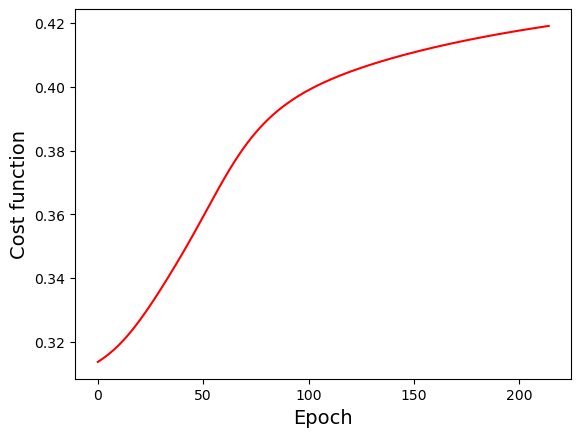

In [89]:
plt.plot(J_gpm,color='red')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Cost function',fontsize=14)

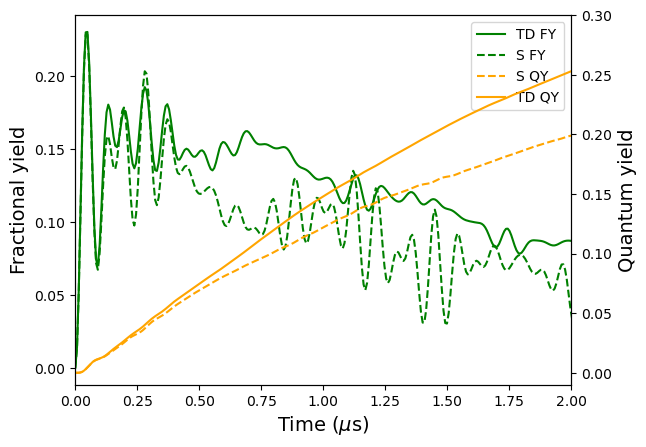

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(H.t/H.gamma_e,f_y_gpm,color='green',label='TD FY')
ax.plot(H.t/H.gamma_e,initial_f_y,color='green',linestyle='--',label='S FY')
ax2 = ax.twinx()
ax2.plot(H.t/H.gamma_e,initial_i_y,color='orange',linestyle='--',label='S QY')
ax2.plot(H.t/H.gamma_e,i_y_gpm,color='orange',label='TD QY')

plt.xlim((0,2))
ax2.set_ylim((-0.01,0.3))
ax.set_xlabel(r'Time ($\mu$s)',fontsize=14)
ax.set_ylabel('Fractional yield',fontsize=14)
ax2.set_ylabel('Quantum yield',fontsize=14)

lns = ax.get_lines() + ax2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

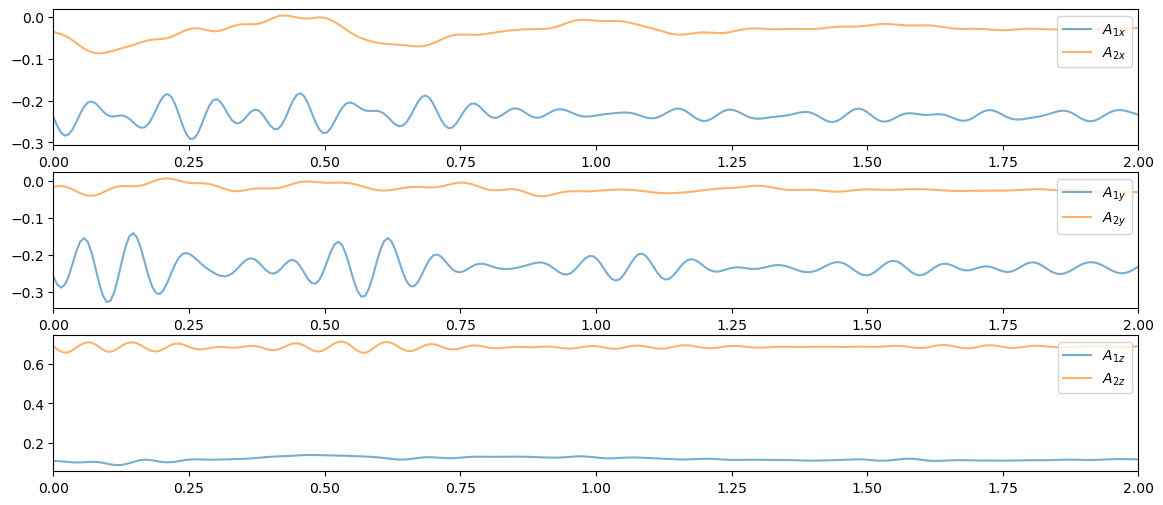

In [91]:
fig = plt.figure(figsize=(14,6))
for i,d in enumerate(['x','y','z']):
    ax=fig.add_subplot(3,1,i+1)
    for j in range(H.n_nuclei):
        ax.plot(H.t/H.gamma_e,H.A[:,j,i,i],label=r'$A_{%i%s}$'%(j+1,d),alpha=0.6)
        ax.set_xlim((0,2))
        plt.legend(loc='upper right')